#### **Library imports**

In [14]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns
from sklearn.metrics import roc_auc_score

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

import models 
from models import get_accuracy
import inspect

#### **Create similar users from training data**

In [15]:
dataset = 'movielens'
n_users = 943
n_items = 1682
n_similar_users = 300 # hyperparameter

# load original training edges
train_edges = np.load('data/' + dataset + '/train_edges.npy')
test_edges = np.load('data/' + dataset + '/test_edges.npy')

# create dicts of positive and negative edges for sampling later (only training edges, not test edges)
positive_edges = dict()
negative_edges = dict() 

for u in range(n_users):
    positive_edges[u] = []
    negative_edges[u] = []

n_train_edges = train_edges.shape[0]

for i in range(n_train_edges):
    u = train_edges[i, 0]
    v = train_edges[i, 1]
    y = train_edges[i, 2]
    if y == 1:
        positive_edges[u].append(v)
    else:
        negative_edges[u].append(v)

np.random.seed(0)
similar_users = np.random.choice(n_users, n_similar_users, replace=False)
print('chosen {} similar users: {}'.format(n_similar_users, similar_users))

# 100% similarity for similar users 
similar_users_train_edges = []
for j in range(len(similar_users)):
    u = similar_users[j]
    for item in positive_edges[u]:
        similar_users_train_edges.append([j + n_users, item, 1])
    for item in negative_edges[u]:
        similar_users_train_edges.append([j + n_users, item, 0])

similar_users_train_edges = np.array(similar_users_train_edges)
np.random.seed(0)
np.random.shuffle(similar_users_train_edges)
np.random.shuffle(similar_users_train_edges)

# similar_users_train_edges 
train_edges_new = np.concatenate((train_edges, similar_users_train_edges), axis=0)
np.random.seed(0)
np.random.shuffle(train_edges_new)
print('train edges shape: ', train_edges.shape)
print('similar users train edges shape: ', similar_users_train_edges.shape)
print('new train edges shape: ', train_edges_new.shape)

# proceed with creating users, items and ratings as usual
user_list_train = train_edges_new[:, 0]
user_list_test = test_edges[:, 0]
item_list_train = train_edges_new[:, 1]
item_list_test = test_edges[:, 1]
rating_list_train = train_edges_new[:, 2].astype('float32')
rating_list_test = test_edges[:, 2].astype('float32')

# compute new n_users, n_items and n_samples
n_users = max(user_list_train.max(), user_list_test.max()) + 1 
n_items = max(item_list_train.max(), item_list_test.max()) + 1
n_samples_train = len(rating_list_train)
n_samples_test = len(rating_list_test)

n_users, n_items, n_samples_train, n_samples_test

chosen 300 similar users: [345 876 558 667 236 261 651 312  14 674  97 230 566  77  55 492 278 818
 658 647 337  31 893 914 294 733 687 320 440 193 144 578 866 311 925 815
 809 700 122 409 571 342 204 231 524  65 317 670 767 214 521 366 145 752
 427 483 380 747 726 666 308 901 630 200 408 683 549 601 443 249 727 271
 403 736  60 596 826 251 744 101 772 142 399 869 240 548 424 653 730   8
 912 175 577 264 942 929 495 346 447 306  34 247 196 103 362 695 722 332
  27 141  30 813 425 479 293 648 817 316 279 390 628 436 891 729 202 769
 649 493 506 750 325 384 941 828 604 814 724 418 741 932 890 916 758 432
 927 295   5 304 936 682 745 907 150 773 520 827 253 267 884 460 751 834
 113 940  37 908 367 158 154  40 283 266 854 922 356 567 742 887 585 478
 350 412 939  62  79 642 181 935 564 298 934 857 285   2 711 389 330 632
  85 386  75 710 487 838 372 768 262   1 625 771 215 889 685 676 568 140
 776 569 462 415 352 364 252 270 255 162 715 874 580 868 895 518 239 538
 561  54  45 363 172 496 

(1243, 1682, 207305, 40381)

#### **Code for surrogate attack using new users**

In [20]:
# model settings
algorithm = 'base-similar({})'.format(n_similar_users)
surrogate = 'CFD'
target = 'CFD'
opt_surrogate = 'adam'
opt_target = 'adam'
lr_surrogate = 0.2
lr_target = 0.2
seed_surrogate = 0
seed_target = 1
dropout_surrogate = 0
dropout_target = 0

# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 7
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparameters
T_surrogate = 25
T_target = 25
Delta = 10000 # 5% ~ 10K perturbations for movielens
n_factors_surrogate = 8
n_factors_target = 8
save_results = True
retain_graph = True 
create_graph = False

if Delta < 100:
    save_results = False

# initialize list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []

perturbations['accuracy-before-surrogate'] = []
perturbations['accuracy-after-surrogate'] = []
perturbations['accuracy-unseen-surrogate'] = []

perturbations['loss-before-surrogate'] = []
perturbations['loss-after-surrogate'] = []
perturbations['loss-unseen-surrogate'] = []

perturbations['accuracy-before-target'] = []
perturbations['accuracy-after-target'] = []
perturbations['accuracy-unseen-target'] = []

perturbations['loss-before-target'] = []
perturbations['loss-after-target'] = []
perturbations['loss-unseen-target'] = []

perturbations['auc-before-surrogate'] = []
perturbations['auc-after-surrogate'] = []
perturbations['auc-unseen-surrogate'] = []

perturbations['auc-before-target'] = []
perturbations['auc-after-target'] = []
perturbations['auc-unseen-target'] = []

# print hyperparam configuration
print('-> Algorithm: ', algorithm)
print()
print('-> T (surrogate): ', T_surrogate)
print('-> T (target): ', T_target)
print('-> Delta: {} ({}%)'.format(Delta, round(Delta * 100 / n_samples_train, 2)))
print('-> Embedding size (surrogate): ', n_factors_surrogate)
print('-> Embedding size (target): ', n_factors_target)
print('-> Device: ', device)
print()
print('-> Surrogate: ', surrogate)
print('-> Target: ', target)
print('-> Surrogate optimizer: ', opt_surrogate)
print('-> Target optimizer: ', opt_target)
print('-> Surrogate learning rate: ', lr_surrogate)
print('-> Target learning rate: ', lr_target)
print('-> Surrogate dropout: ', dropout_surrogate)
print('-> Target dropout: ', dropout_target)
print('-> Surrogate seed: ', seed_surrogate)
print('-> Target seed: ', seed_target)
print()
print('-> Retain graph: ', retain_graph)
print('-> Create graph: ', create_graph)
print('-> Save results: ', save_results)

# load users, items and ratings as tensors
users = torch.tensor(user_list_train, device = device)
items = torch.tensor(item_list_train, device = device)
ratings = torch.tensor(rating_list_train, device = device, requires_grad = True)

# only those edges are allowed to be perturbed whose mask entry is False
mask = torch.ones_like(ratings).bool()
mask[users >= 943] = False # perturbations only allowed for newly injected similar users
mask[ratings == 1] = True # positive edges cannot be perturbed even for new users

# perturbs keeps track of perturbed edges by marking them as False
perturbs = torch.ones_like(ratings).bool()

# generate tensors out of validation data
users_test = torch.tensor(user_list_test, device = device)
items_test = torch.tensor(item_list_test, device = device)
ratings_test = torch.tensor(rating_list_test, device = device)

# sample random negative edges to perturb for baseline
if 'base' in algorithm:
    edges = mask.int().detach().to('cpu').numpy()
    neg_edges = np.where(edges == 0)[0]
    np.random.seed(0)
    edges_to_perturb = np.random.choice(neg_edges, size=Delta, replace = False) # sample Delta edges randomly and perturb one by one inside loop 

# for each perturbation do the following
for delta in tqdm(range(Delta), desc='-> Perturbations'):

    # define surrogate model and it's parameters
    torch.manual_seed(seed_surrogate)
    model = getattr(models, surrogate)(n_users, n_items, n_factors_surrogate, dropout_surrogate).to(device)

    # define optimizer and loss function
    if 'adam' in opt_surrogate:
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_surrogate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr = lr_surrogate)
    loss_fn = nn.BCELoss(reduction = 'mean')

    # inner loop training process
    model.train()
    for i in range(T_surrogate):
        y_hat = model(users, items).reshape(ratings.shape)
        loss = loss_fn(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer.step()
    model.eval()

    # compute and store accuracy of model after T training steps
    with torch.no_grad():
        # training accuracy and loss including perturbed edges
        y_hat = model(users, items).reshape(ratings.shape)
        perturbations['accuracy-before-surrogate'].append(get_accuracy(y_hat, ratings))
        perturbations['loss-before-surrogate'].append(loss_fn(y_hat, ratings).item())

        # compute training AUROC including perturbed edges
        y_pred = y_hat.detach().clone().to('cpu').numpy()
        y_actual = ratings.detach().clone().to('cpu').numpy() 
        perturbations['auc-before-surrogate'].append(roc_auc_score(y_actual, y_pred))

        # training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs)
        ratings_masked = torch.masked_select(ratings, perturbs)
        perturbations['accuracy-after-surrogate'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss-after-surrogate'].append(loss_fn(y_hat_masked, ratings_masked).item())

        # compute training AUROC excluding perturbed edges
        y_pred = y_hat_masked.detach().clone().to('cpu').numpy()
        y_actual = ratings_masked.detach().clone().to('cpu').numpy()
        perturbations['auc-after-surrogate'].append(roc_auc_score(y_actual, y_pred))

    # compute and store accuracy of surrogate model on unseen data
    with torch.no_grad():
        y_hat = model(users_test, items_test).reshape(ratings_test.shape)
        perturbations['accuracy-unseen-surrogate'].append(get_accuracy(y_hat, ratings_test))
        perturbations['loss-unseen-surrogate'].append(loss_fn(y_hat, ratings_test).item())

        # compute unseen AUROC
        y_pred = y_hat.detach().clone().to('cpu').numpy()
        y_actual = ratings_test.detach().clone().to('cpu').numpy()
        perturbations['auc-unseen-surrogate'].append(roc_auc_score(y_actual, y_pred))

    # compute meta gradient
    if 'meta' in algorithm:
        meta_grad = torch.autograd.grad(loss, ratings)[0]

    # define evaluation model
    torch.manual_seed(seed_target)
    eval_model = getattr(models, target)(n_users, n_items, n_factors_target, dropout_target).to(device)

    # define optimizer and loss function for evaluation
    if 'adam' in opt_target:
        optimizer_eval = torch.optim.Adam(eval_model.parameters(), lr = lr_target)
    else:
        optimizer_eval = torch.optim.SGD(eval_model.parameters(), lr = lr_target)
    loss_fn_eval = nn.BCELoss(reduction = 'mean')

    # detach ratings and perturbs for eval model
    ratings_eval = ratings.detach().clone()
    perturbs_eval = perturbs.detach().clone()

    # inner train  evaluation model
    eval_model.train()
    for i in range(T_target):
        y_hat = eval_model(users, items).reshape(ratings_eval.shape)
        loss_eval = loss_fn_eval(y_hat, ratings_eval)
        optimizer_eval.zero_grad()
        loss_eval.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer_eval.step()
    eval_model.eval()

    # compute and store accuracy of eval model after T training steps
    with torch.no_grad():
        # training accuracy and loss including perturbed edges
        y_hat = eval_model(users, items).reshape(ratings_eval.shape)
        perturbations['accuracy-before-target'].append(get_accuracy(y_hat, ratings_eval))
        perturbations['loss-before-target'].append(loss_fn_eval(y_hat, ratings_eval).item())

        # compute training AUROC including perturbed edges
        y_pred = y_hat.detach().clone().to('cpu').numpy()
        y_actual = ratings_eval.detach().clone().to('cpu').numpy() 
        perturbations['auc-before-target'].append(roc_auc_score(y_actual, y_pred))

        # training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs_eval)
        ratings_masked = torch.masked_select(ratings_eval, perturbs_eval)
        perturbations['accuracy-after-target'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss-after-target'].append(loss_fn_eval(y_hat_masked, ratings_masked).item())

        # compute training AUROC excluding perturbed edges
        y_pred = y_hat_masked.detach().clone().to('cpu').numpy()
        y_actual = ratings_masked.detach().clone().to('cpu').numpy()
        perturbations['auc-after-target'].append(roc_auc_score(y_actual, y_pred))

    # compute and store accuracy of target model on unseen data
    with torch.no_grad():
        y_hat = eval_model(users_test, items_test).reshape(ratings_test.shape)
        perturbations['accuracy-unseen-target'].append(get_accuracy(y_hat, ratings_test))
        perturbations['loss-unseen-target'].append(loss_fn(y_hat, ratings_test).item())

        # compute unseen AUROC
        y_pred = y_hat.detach().clone().to('cpu').numpy()
        y_actual = ratings_test.detach().clone().to('cpu').numpy()
        perturbations['auc-unseen-target'].append(roc_auc_score(y_actual, y_pred))

    # select best edge and perform perturbation
    with torch.no_grad():
        if 'meta' in algorithm:
            meta_grad[mask == True] = 0
            best_edge = meta_grad.argmax().item()
            
            if mask[best_edge] == False:
                # if this condition is true, it means there is not even a single eligible unperturbed edge with a positive meta-gradient
                ratings[best_edge] = 1
                perturbs[best_edge] = False
                mask[best_edge] = True
                perturbations['edges'].append(best_edge)
                perturbations['metagrad'].append(meta_grad[best_edge].item())
            else:
                perturbations['edges'].append(-1)
                perturbations['metagrad'].append(0)

        else:
            best_edge = edges_to_perturb[delta]
            ratings[best_edge] = 1 
            perturbs[best_edge] = False
            mask[best_edge] = True

            perturbations['edges'].append(best_edge)
            perturbations['metagrad'].append(-1)

sleep(1)
# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# process results
perturbations = pd.DataFrame(perturbations)
filename = '{}({},{})-{}({},{})-{}-D={}-T({},{})-lr({},{})-seed({},{})-drop({},{})'.format(surrogate, n_factors_surrogate, opt_surrogate, target, n_factors_target, opt_target, algorithm, Delta, T_surrogate, T_target, lr_surrogate, lr_target, seed_surrogate, seed_target, dropout_surrogate, dropout_target)
print('-> File name: {}'.format(filename))
if save_results:
    perturbations.to_csv('results/' + dataset + '/' + filename + '.csv')

-> Algorithm:  base-similar(300)

-> T (surrogate):  25
-> T (target):  25
-> Delta: 10000 (4.82%)
-> Embedding size (surrogate):  8
-> Embedding size (target):  8
-> Device:  cuda:7

-> Surrogate:  CFD
-> Target:  CFD
-> Surrogate optimizer:  adam
-> Target optimizer:  adam
-> Surrogate learning rate:  0.2
-> Target learning rate:  0.2
-> Surrogate dropout:  0
-> Target dropout:  0
-> Surrogate seed:  0
-> Target seed:  1

-> Retain graph:  True
-> Create graph:  False
-> Save results:  True


-> Perturbations: 100%|██████████| 10000/10000 [58:41<00:00,  2.84it/s]


-> Execution time: 00h 58m 42s
-> File name: CFD(8,adam)-CFD(8,adam)-base-similar(300)-D=10000-T(25,25)-lr(0.2,0.2)-seed(0,1)-drop(0,0)


In [21]:
print('File name: ', filename)
if 'meta' in algorithm:
    print('Max meta-gradient: ', perturbations['metagrad'].max())
perturbations

File name:  CFD(8,adam)-CFD(8,adam)-base-similar(300)-D=10000-T(25,25)-lr(0.2,0.2)-seed(0,1)-drop(0,0)


,edges,metagrad,accuracy-before-surrogate,accuracy-after-surrogate,accuracy-unseen-surrogate,loss-before-surrogate,loss-after-surrogate,loss-unseen-surrogate,accuracy-before-target,accuracy-after-target,accuracy-unseen-target,loss-before-target,loss-after-target,loss-unseen-target,auc-before-surrogate,auc-after-surrogate,auc-unseen-surrogate,auc-before-target,auc-after-target,auc-unseen-target
0,105492,-1,0.854393,0.854393,0.792551,0.328803,0.328803,0.500508,0.850500,0.850500,0.787177,0.335426,0.335426,0.503198,0.932393,0.932393,0.869774,0.929496,0.929496,0.865710
1,116417,-1,0.854364,0.854368,0.792576,0.328787,0.328773,0.500508,0.850471,0.850476,0.787177,0.335443,0.335431,0.503180,0.932400,0.932405,0.869785,0.929489,0.929494,0.865721
2,176825,-1,0.854442,0.854445,0.792700,0.328757,0.328743,0.500482,0.850525,0.850528,0.787128,0.335436,0.335425,0.503170,0.932413,0.932418,0.869807,0.929493,0.929497,0.865725
3,197613,-1,0.854427,0.854435,0.792675,0.328773,0.328755,0.500511,0.850505,0.850513,0.787350,0.335435,0.335412,0.503144,0.932407,0.932413,0.869793,0.929494,0.929503,0.865740
4,118989,-1,0.854567,0.854574,0.792650,0.328770,0.328753,0.500547,0.850438,0.850449,0.787152,0.335464,0.335435,0.503137,0.932409,0.932415,0.869777,0.929483,0.929494,0.865732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,178585,-1,0.833685,0.843941,0.782175,0.368182,0.351715,0.515439,0.831355,0.841088,0.780169,0.372499,0.357096,0.510462,0.913273,0.923137,0.858111,0.911076,0.920247,0.860463
9996,114935,-1,0.833636,0.843879,0.782175,0.368177,0.351717,0.515435,0.831389,0.841117,0.780367,0.372503,0.357102,0.510464,0.913274,0.923137,0.858105,0.911075,0.920246,0.860472
9997,115309,-1,0.833665,0.843934,0.782274,0.368201,0.351723,0.515398,0.831403,0.841096,0.780218,0.372474,0.357080,0.510467,0.913262,0.923130,0.858121,0.911087,0.920255,0.860465
9998,138471,-1,0.833617,0.843913,0.782323,0.368227,0.351754,0.515390,0.831471,0.841192,0.780392,0.372481,0.357073,0.510376,0.913248,0.923116,0.858122,0.911083,0.920257,0.860519


File name:  CFD(8,adam)-CFD(8,adam)-base-similar(300)-D=10000-T(25,25)-lr(0.2,0.2)-seed(0,1)-drop(0,0)


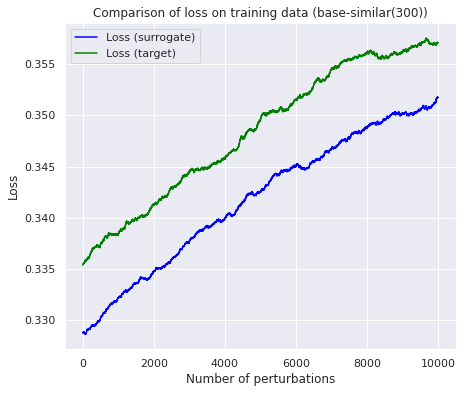

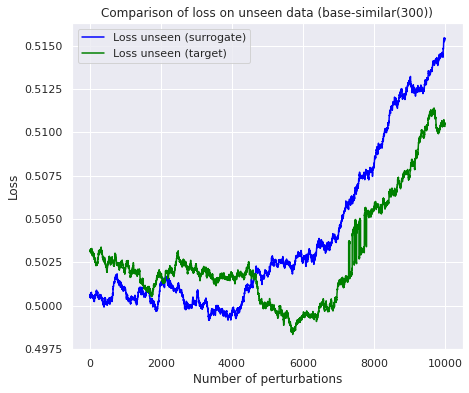

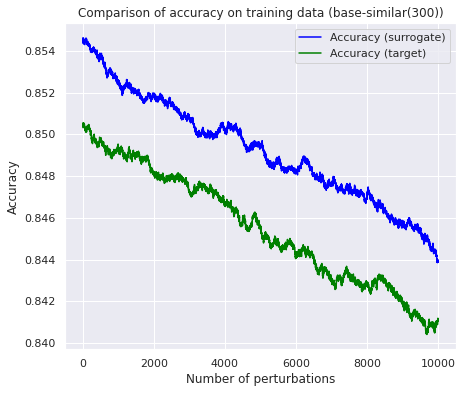

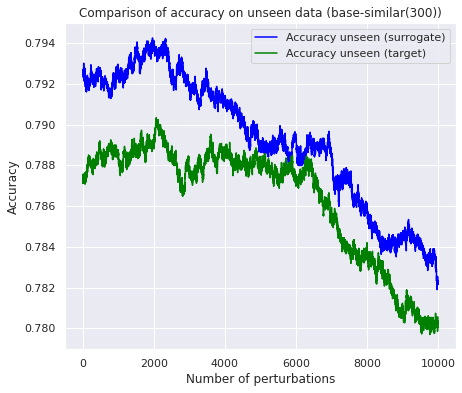

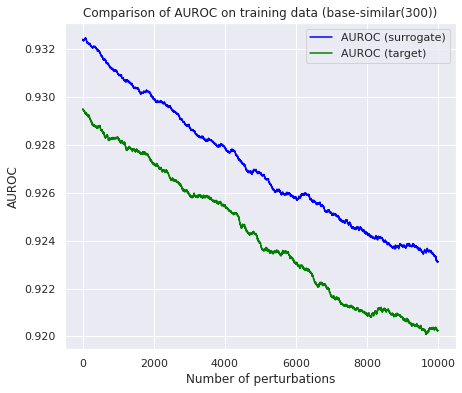

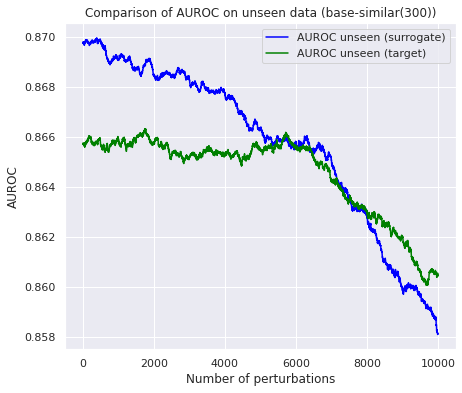

In [22]:
# Process perturbations data
perturbations_reset = perturbations.reset_index()
perturbations_reset.columns = ['# Perturbations', 'Perturbed edge', 'Meta gradient', 'Accuracy including perturbed edges (surrogate)', 'Accuracy excluding perturbed edges (surrogate)', 'Accuracy unseen (surrogate)', 'Loss including perturbed edges (surrogate)', 'Loss excluding perturbed edges (surrogate)', 'Loss unseen (surrogate)', 'Accuracy including perturbed edges (target)', 'Accuracy excluding perturbed edges (target)', 'Accuracy unseen (target)', 'Loss including perturbed edges (target)', 'Loss excluding perturbed edges (target)', 'Loss unseen (target)', 'AUROC including perturbed edges (surrogate)', 'AUROC excluding perturbed edges (surrogate)', 'AUROC unseen (surrogate)', 'AUROC including perturbed edges (target)', 'AUROC excluding perturbed edges (target)', 'AUROC unseen (target)']
perturbations_reset

# Figure specifications
sns.set_theme()
figsize = (7, 6)
print('File name: ', filename)

# Loss on training data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of loss on training data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Loss')
plt.legend(labels = ['Loss (surrogate)', 'Loss (target)'])
if save_results: 
    fig.savefig('plots/' + dataset + '/losses-' + filename + '.png')
plt.show()

# Loss on unseen data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss unseen (surrogate)', color = 'blue').set_title('Comparison of loss on unseen data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss unseen (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Loss')
plt.legend(labels = ['Loss unseen (surrogate)', 'Loss unseen (target)'])
if save_results: 
    fig.savefig('plots/' + dataset + '/losses-unseen-' + filename + '.png')
plt.show()

# Accuracy on training data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of accuracy on training data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Accuracy')
plt.legend(labels = ['Accuracy (surrogate)', 'Accuracy (target)'])
if save_results:
    fig.savefig('plots/' + dataset + '/accuracy-' + filename + '.png')
plt.show()

# Accuracy on unseen data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy unseen (surrogate)', color = 'blue').set_title('Comparison of accuracy on unseen data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy unseen (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Accuracy')
plt.legend(labels = ['Accuracy unseen (surrogate)', 'Accuracy unseen (target)'])
if save_results: 
    fig.savefig('plots/' + dataset + '/accuracy-unseen-' + filename + '.png')
plt.show()

# AUROC on training data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'AUROC excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of AUROC on training data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'AUROC excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('AUROC')
plt.legend(labels = ['AUROC (surrogate)', 'AUROC (target)'])
if save_results:
    fig.savefig('plots/' + dataset + '/AUROC-' + filename + '.png')
plt.show()

# AUROC on unseen data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'AUROC unseen (surrogate)', color = 'blue').set_title('Comparison of AUROC on unseen data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'AUROC unseen (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('AUROC')
plt.legend(labels = ['AUROC unseen (surrogate)', 'AUROC unseen (target)'])
if save_results:
    fig.savefig('plots/' + dataset + '/AUROC-unseen-' + filename + '.png')
plt.show()